In [18]:
import os
import pandas as pd
from estnltk import Text
from tqdm import tqdm
from itertools import chain
import matplotlib.pyplot as plt
import json
import pickle
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

In [2]:
df = pd.read_csv("obl_fraasid_verb_all_temp.csv", sep=";", encoding="utf-8")

In [3]:
df2 = df[["verbobl", "isikumäärus", "aja-kohamäärus", "muu"]]
df2

,verbobl,isikumäärus,aja-kohamäärus,muu
0,saama - abl (kellelt/millelt),vahel,vahel,mitte kunagi
1,tulema - abl (kellelt/millelt),vahel,vahel,mitte kunagi
2,küsima - abl (kellelt/millelt),alati,mitte kunagi,mitte kunagi
3,nõudma - abl (kellelt/millelt),alati,mitte kunagi,mitte kunagi
4,võtma - abl (kellelt/millelt),vahel,vahel,mitte kunagi
...,...,...,...,...
10574,musitseerima - in (kelles/milles),mitte kunagi,alati,muu
10575,kõigutama - in (kelles/milles),mitte kunagi,mitte kunagi,muu
10576,kätlema - in (kelles/milles),mitte kunagi,alati,muu
10577,kõmmutama - in (kelles/milles),mitte kunagi,alati,mitte kunagi


In [4]:
verbdict = {}

for i in range(len(df2)):
    verb = df2.iloc[i]["verbobl"].split("-")[0].strip()
    kääne = df2.iloc[i]["verbobl"].split("-")[1].strip()
    isik = df2.iloc[i]["isikumäärus"]
    aegkoht = df2.iloc[i]["aja-kohamäärus"]
    muu = df2.iloc[i]["muu"]
    
    if verb in verbdict.keys():
        new_value = verbdict[verb]
        new_value.append({kääne:(isik, aegkoht,muu)})
        verbdict[verb] = new_value
    else:
        verbdict[verb] = [{kääne:(isik, aegkoht,muu)}]

In [5]:
# koonda iga verbi jaoks määruste valikud
# nt "saama" puhul on isik {alati, vahel, mitte kunagi}

final = {}

for key in verbdict.keys():
    valuedata = verbdict[key]
    isik = []
    koht = []
    muu = []
    if len(valuedata) > 1:
        for f, subdict in enumerate(valuedata):
            for elem in subdict.keys():
                isik.append(valuedata[f][elem][0])
                koht.append(valuedata[f][elem][1])
                muu.append(valuedata[f][elem][2])
    else:
        #print(valuedata[0].keys())
        #break
        k = list(valuedata[0].keys())[0]
        isik.append(valuedata[0][k][0])
        koht.append(valuedata[0][k][1])
        muu.append(valuedata[0][k][2])
        
    
    final[key] = (set(isik), set(koht), set(muu))
    

In [7]:
data = pd.read_csv("obl_1000_verb_lem.csv", sep=";", encoding="utf-8")
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label,verb_lemma
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1,['osalema']
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1,['investeerima']
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1,['andma']
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1,['saama']
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1,['kargama']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0,['loopima']
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0,['kommenteerima']
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsii

In [8]:
def get_verb_based(phrase, verbs, final, verb_dict):
    
    is_removable = 0
    #print(len(verbs))
    if len(verbs) == 1: # one verb form to test
        #print("siin0", verbs[0], final[verbs[0]])
        if verbs[0] in verb_dict.keys():
            #print("siin 1", verbs, verbs[0], verbs[0] in list(verb_dict.keys()), list(verb_dict.keys()).index(verbs[0]) )
            text = Text(phrase)
            text = text.tag_layer('morph_analysis')
            phrase_forms = list(set(chain.from_iterable(list(text["morph_analysis"].form))))
            phrase_forms = [f.replace("sg", "").strip() for f in phrase_forms if f!=""]
            if len(phrase_forms)>0: # start checking if the phrase form is among the verb dict forms
                found_match = False
                valuedata = verb_dict[verbs[0]]
                for f, subdict in enumerate(valuedata):
                    for elem in subdict.keys():
                        for pf in phrase_forms:
                            if pf in elem: # phrase form is in verb form
                                found_match = True
                                verb_values = valuedata[f][elem]
                                if verb_values[0] == "alati": # is person -> not removable
                                    is_removable = 0
                                elif verb_values[1] == "alati" and verb_values[0] != "alati": # is mostly location->removable
                                    is_removable = 1
                                else:
                                    is_removable = 0
                if not found_match: # no luck with forms
                    verb_values = final[verbs[0]]
                    if "alati" in verb_values[0]: # "alati" among person values
                        is_removable = 0
                    elif "alati" in verb_values[1] and not "alati" in verb_values[0]: # is mostly location->removable
                        is_removable = 1
                    else:
                        is_removable = 0
        #else: # no verb in the list, so say it's not removable
        #    return 0
    
    elif len(verbs) > 1: # multiple verb forms to test
        
        for v in verbs:
            matches = False
            if v in list(verb_dict.keys()):
                matches = True
                #print("siin3", v, v in list(verb_dict.keys()))
                text = Text(phrase)
                text = text.tag_layer('morph_analysis')
                phrase_forms = list(set(chain.from_iterable(list(text["morph_analysis"].form))))
                phrase_forms = [f.replace("sg", "").strip() for f in phrase_forms if f!=""]
                if len(phrase_forms)>0: # start checking if the phrase form is among the verb dict forms
                    found_match = False
                    valuedata = verb_dict[v]
                    for f, subdict in enumerate(valuedata):
                        for elem in subdict.keys():
                            for pf in phrase_forms:
                                if pf in elem: # phrase form is in verb form
                                    found_match = True
                                    verb_values = valuedata[f][elem]
                                    if verb_values[0] == "alati": # is person -> not removable
                                        is_removable = 0
                                    elif verb_values[1] == "alati" and verb_values[0] != "alati": # is mostly location->removable
                                        is_removable = 1
                                    else:
                                        is_removable = 0
                    if not found_match: # no luck with forms
                        verb_values = final[v]
                        if "alati" in verb_values[0]: # "alati" among person values
                            is_removable = 0
                        elif "alati" in verb_values[1] and not "alati" in verb_values[0]: # is mostly location->removable
                            is_removable = 1
                        else:
                            is_removable = 0
                
                
                
        
        #if matches = False: # no verb in the list, so say it's not removable
        #    return 0
        
        
        
    
    return is_removable

In [9]:
is_removable_data = []

for i in tqdm(range(len(data))):
    phrase = data.iloc[i]["removed"]    
    verb = data.iloc[i]["verb_lemma"].strip('][').replace("'", "").split(', ')
    
    #print(phrase, verb)
    
    is_rem = get_verb_based(phrase,verb, final, verbdict)
    
    is_removable_data.append(is_rem)

    #break

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 807.48it/s]


In [10]:
#data["phrase_is_removable"] = is_removable_data
#data["phrase_is_time"] = is_time_data
#data["can_be_removed"] = "no"
data["remove_label"] = is_removable_data

In [11]:
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label,verb_lemma,remove_label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1,['osalema'],1
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1,['investeerima'],0
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1,['andma'],0
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1,['saama'],1
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1,['kargama'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0,['loopima'],1
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0,['kommenteerima'],0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , s

In [12]:
predicted = list(data['remove_label'])
y_test = list(data['label'])

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision.round(3)))
print('recall: {}'.format(recall.round(3)))
print('fscore: {}'.format(fscore.round(3)))
print('support: {}'.format(support.round(3)))

try:
    precision = precision_score(y_test, predicted, pos_label=1, average='binary')
    recall = recall_score(y_test, predicted, pos_label=1, average='binary')
except:
    precision = precision_score(y_test, predicted, labels=[1], average='micro')
    recall = recall_score(y_test, predicted, labels=[1], average='micro')
print('precision: ',precision.round(3))
print('recall: ',recall.round(3))

precision: [0.494 0.494]
recall: [0.528 0.46 ]
fscore: [0.511 0.476]
support: [500 500]
precision:  0.494
recall:  0.46


In [13]:
data["match"] = data.remove_label.eq(data.label) # true if annotation and prediction are the same

In [14]:
data.value_counts("match")

match
False    506
True     494
Name: count, dtype: int64

In [15]:
data.value_counts("remove_label")

remove_label
0    534
1    466
Name: count, dtype: int64

In [16]:
# Compute global precision and recall
precision1, recall1, thresh1 = precision_recall_curve(y_test, predicted, pos_label=1)

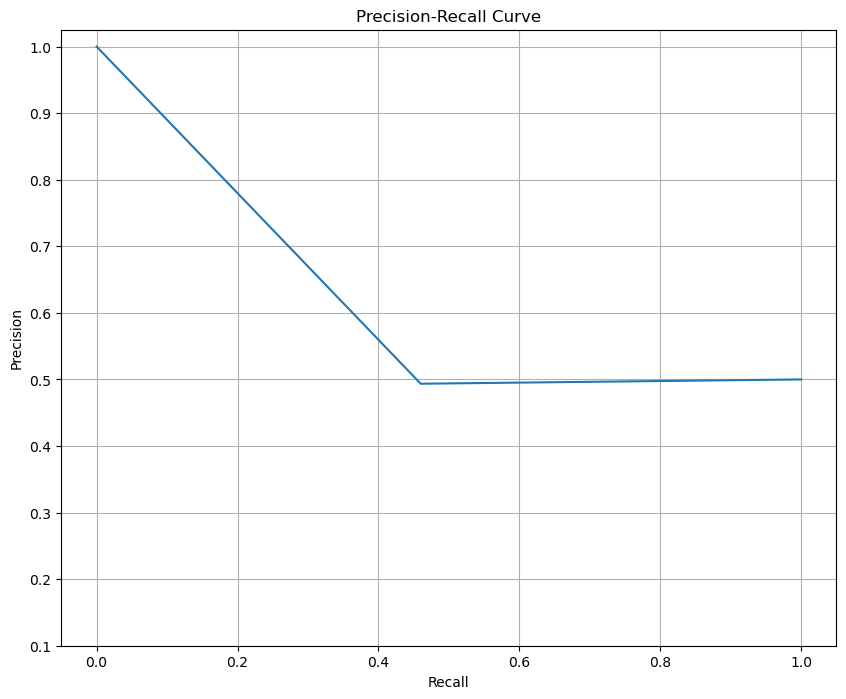

In [19]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)

In [21]:
roc_auc = auc(fpr, tpr)

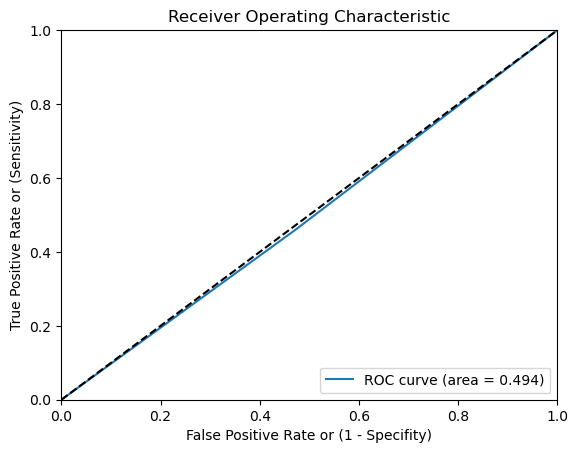

In [22]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [23]:
#data.to_csv("obl_gpt_large1_verboblcase_v1_benchmark1.csv", index=False, sep=";", encoding="utf-8")